<h2>Preparation and Exploration</h2>

In [511]:
# importing libraries
import pandas            as pd                          # data science essentials
import matplotlib.pyplot as plt                         # data visualization
import seaborn           as sns                         # enhanced data viz
from sklearn.model_selection import train_test_split    # train-test split
from sklearn.linear_model import LogisticRegression     # logistic regression
import statsmodels.formula.api as smf                   # logistic regression
from sklearn.metrics import confusion_matrix            # confusion matrix
from sklearn.metrics import roc_auc_score               # auc score
from sklearn.neighbors import KNeighborsClassifier      # KNN for classification
from sklearn.neighbors import KNeighborsRegressor       # KNN for regression
from sklearn.preprocessing import StandardScaler        # standard scaler
from sklearn.tree import DecisionTreeClassifier         # classification trees
from sklearn.tree import plot_tree                      # tree plots
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer                 # customizable scorer


# loading data
got = pd.read_excel(io = './GOT_character_predictions.xlsx')


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# displaying the head of the dataset
got.head(n = 10)

S.No                  name                 title   culture  dateOfBirth              mother            father                heir            house               spouse  book1_A_Game_Of_Thrones  book2_A_Clash_Of_Kings  book3_A_Storm_Of_Swords  book4_A_Feast_For_Crows  book5_A_Dance_with_Dragons  isAliveMother  isAliveFather  isAliveHeir  isAliveSpouse  isMarried  isNoble   age  numDeadRelations  popularity  isAlive
0     1  Viserys II Targaryen                   NaN       NaN          NaN  Rhaenyra Targaryen  Daemon Targaryen  Aegon IV Targaryen              NaN                  NaN                        0                       0                        0                        0                           0            1.0            0.0          0.0            NaN          0        0   NaN                11    0.605351        0
1     2           Walder Frey  Lord of the Crossing  Rivermen        208.0                 NaN               NaN                 NaN       House Frey          Perra Royce                        1                       1                        1                        1                           1            NaN            NaN          NaN            1.0          1        1  97.0                 1    0.896321        1
2     3          Addison Hill                   Ser       NaN          NaN                 NaN               NaN                 NaN      House Swyft                  NaN                        0                       0                        0                        1                           0            NaN            NaN          NaN            NaN          0        1   NaN                 0    0.267559        1
3     4           Aemma Arryn                 Queen       NaN         82.0                 NaN               NaN                 NaN      House Arryn  Viserys I Targaryen                        0                       0                        0                        0                           0            NaN            NaN          NaN            0.0          1        1  23.0                 0    0.183946        0
4     5        Sylva Santagar            Greenstone   Dornish        276.0                 NaN               NaN                 NaN   House Santagar      Eldon Estermont                        0                       0                        0                        1                           0            NaN            NaN          NaN            1.0          1        1  29.0                 0    0.043478        1
5     6      Tommen Baratheon                   NaN       NaN          NaN    Cersei Lannister  Robert Baratheon  Myrcella Baratheon              NaN                  NaN                        0                       0                        0                        0                           0            1.0            1.0          1.0            NaN          0        0   NaN                 5    1.000000        1
6     7      Valarr Targaryen      Hand of the King  Valyrian        183.0                 NaN               NaN                 NaN  House Targaryen      Kiera of Tyrosh                        0                       0                        0                        0                           0            NaN            NaN          NaN            1.0          1        1  26.0                 0    0.431438        0
7     8   Viserys I Targaryen                   NaN       NaN          NaN    Alyssa Targaryen  Baelon Targaryen  Rhaenyra Targaryen              NaN                  NaN                        0                       0                        0                        0                           0            1.0            1.0          1.0            NaN          0        0   NaN                 5    0.678930        0
8     9               Wilbert                   Ser       NaN          NaN                 NaN               NaN                 NaN              NaN                  NaN                        0                   

In [512]:
got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

<h4>Define functions</h4>

In [513]:
#########################
# missing values_flagger
#########################
def mv_flagger(df):

    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df

        
########################################
# optimal_neighbors for KNN
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize   = True,
                      pct_test      = 0.1,
                      seed          = 219,
                      response_type = 'reg',
                      max_neighbors = 20,
                      show_viz      = True):
    
    if standardize == True:
        # optionally standardizing x_data
        scaler = StandardScaler()
        scaler.fit(x_data)
        x_scaled     = scaler.transform(x_data)
        x_scaled_df  = pd.DataFrame(x_scaled)
        x_data       = x_scaled_df

    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)

    # creating lists for training set accuracy and test set accuracy
    train_accuracy = []
    test_accuracy = []
       
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        train_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, train_accuracy, label = "train accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_confusion matrix
########################################
def visual_cm(true_y, pred_y, labels = None):

    # setting labels
    lbls = labels

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)

    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

<h4>Load the data dictionary</h4>

In [514]:
# pulling up data dictionary
got_description = pd.read_excel('./GOT_data_dictionary.xlsx')


# displaying the data dictionary
got_description

S.No                                                            Character number (by order of appearance)
0                         name                                                                                       Character name
1                        title                                                            Honorary title(s) given to each character
2                         male                                                                                 1 = male, 0 = female
3                      culture                                                          Indicates the cultural group of a character
4                  dateOfBirth                                        Known dates of birth for each character (measurement unknown)
5                       mother                                                                        Character's biological mother
6                       father                                                                        Character's biological father
7                         heir                                                                          Character's biological heir
8                        house                               Indicates a character's allegiance to a house (i.e. a powerful family)
9                       spouse                                                                                Character's spouse(s)
10     book1_A_Game_Of_Thrones                                                     1 = appeared in book, 0 = did not appear in book
11      book2_A_Clash_Of_Kings                                                     1 = appeared in book, 0 = did not appear in book
12     book3_A_Storm_Of_Swords                                                     1 = appeared in book, 0 = did not appear in book
13     book4_A_Feast_For_Crows                                                     1 = appeared in book, 0 = did not appear in book
14  book5_A_Dance_with_Dragons                                                     1 = appeared in book, 0 = did not appear in book
15               isAliveMother                                                                             1 = alive, 0 = not alive
16               isAliveFather                                                                             1 = alive, 0 = not alive
17                 isAliveHeir                                                                             1 = alive, 0 = not alive
18               isAliveSpouse                                                                             1 = alive, 0 = not alive
19                   isMarried                                                                         1 = married, 0 = not married
20                     isNoble                                                                             1 = noble, 0 = not noble
21                         age                                                                             Character's age in years
22            numDeadRelations                                       Total number of deceased relatives throughout all of the books
23                  popularity  Indicates the popularity of a character (1 = extremely popular (max), 0 = extremely unpopular (m...
24                     isAlive                                                                             1 = alive, 0 = not alive

<h4>Drop features</h4>

In [515]:
# dropping index features
got = got.drop(labels = 'S.No',
                       axis   = 1)


# checking results
got.columns

Index(['name', 'title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive'], dtype='object')

<h4>Missing value detection</h4>

In [516]:
# checking each feature for missing values
got.isnull().sum(axis = 0)

name                             0
title                         1008
culture                       1269
dateOfBirth                   1513
mother                        1925
father                        1920
heir                          1923
house                          427
spouse                        1670
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                 1925
isAliveFather                 1920
isAliveHeir                   1923
isAliveSpouse                 1670
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
dtype: int64

<h4>Develop missing value and categorical encoding strategies</h4>

In [517]:
# name           - (discrete) use gender guesser, and then feature out, drop original

# title          - (categorical) drop (very dirty; insufficient domain knowledge)
# culture        - (discrete) feature out, drop original
# dateOfBirth    - (interval) drop
# mother         - (discrete) feature out, drop original
# father         - (discrete) feature out, drop original
# heir           - (discrete) feature out, drop original
# house          - (categorical) drop (very dirty; insufficient domain knowledge)
# spouse         - (discrete) feature out, drop original

# isAliveMother  - (interval) impute 0
# isAliveFather  - (interval) impute 0
# isAliveHeir    - (interval) impute 0
# isAliveSpouse  - (interval) impute 0
# age            - (continuous) impute with mean or mode

# isFamAlive  - (interval) create a new feature if either mother, father, spouse, or heir is alive

<h4>Guess the gender (drop this feature later)</h4>

In [518]:
# # installing gender_guesser
# %pip install gender_guesser

In [519]:
# # importing libraries
# import gender_guesser.detector as gender

In [520]:
# # STEP 1: splitting names to given name and family name

# # placeholder list
# placeholder_lst = []

# # looping over each name
# for index, col in got.iterrows():
    
#     # splitting email domain at '@'
#     split_name = got.loc[index, 'name'].split(sep = ' ')
    
#     # appending placeholder_lst with the results
#     placeholder_lst.append(split_name)
    

# # converting placeholder_lst into a DataFrame 
# got_df = pd.DataFrame(placeholder_lst)


# # displaying the results
# got_df


In [521]:
# # STEP 2: concatenating with original DataFrame

# # renaming column to concatenate
# got_df.columns = ['given_name' , 'family_name', 'family_name_2', '0', '0', '0']


# # concatenating given_name with got DataFrame
# got = pd.concat([got, got_df['given_name']],
#                      axis = 1)


# # printing value counts of given_name
# got.loc[: ,'given_name'].value_counts()

In [522]:
# # STEP 3: guessing gender based on given name

# # placeholder list
# placeholder_lst = []

# # looping to guess gender
# for name in got['given_name']:
#     guess = gender.Detector().get_gender(name)
#     placeholder_lst.append(guess)

# # converting list into a series
# got['gender_guess'] = pd.Series(placeholder_lst)


# # checking results
# got['gender_guess'].value_counts()

In [523]:
# output from gender_guess
# unknown      1385
# male          381
# female        125
# mostly_male    24
# mostly_female  21
# andy           10

In [524]:
# # getting dummies for gender_guess
# got = pd.get_dummies(data    = got,
#                      columns = ['gender_guess'])

# # grouping variables
# got['gender_guess_male'] =  got['gender_guess_andy'] + got['gender_guess_male'] \
#                             + got['gender_guess_mostly_male']
# got['gender_guess_female'] =  got['gender_guess_female'] + got['gender_guess_mostly_female']


In [525]:
# after grouping
# gender_guess_unknown      1385
# gender_guess_male          415
# gender_guess_female        146

The unkonwn portion is too big to predict actual gender effectively. As such, drop this feature.

<h4>Drop features</h4>

In [526]:
# dropping columns
got = got.drop('name', axis = 1)
got = got.drop('title', axis = 1)
got = got.drop('culture', axis = 1)
got = got.drop('dateOfBirth', axis = 1)
got = got.drop('mother', axis = 1)
got = got.drop('father', axis = 1)
got = got.drop('heir', axis = 1)
got = got.drop('house', axis = 1)
got = got.drop('spouse', axis = 1)

# checking the result
got.columns

Index(['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive'], dtype='object')

<h4>Impute missing values</h4>
Missing values from dummy variables should be 0.

In [527]:
# imputing missing values with 0
got['isAliveMother'] = got['isAliveMother'].fillna(0)
got['isAliveFather'] = got['isAliveFather'].fillna(0)
got['isAliveHeir'] = got['isAliveHeir'].fillna(0)
got['isAliveSpouse'] = got['isAliveSpouse'].fillna(0)

# checking results
got['isAliveMother'].isnull().sum(axis = 0)
got['isAliveFather'].isnull().sum(axis = 0)
got['isAliveHeir'].isnull().sum(axis = 0)
got['isAliveSpouse'].isnull().sum(axis = 0)


0

<h4>Flag missing values</h4>

In [528]:
# running the mv_flagger function
got = mv_flagger(df = got)


# checking results
got.columns

Index(['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive', 'm_age'], dtype='object')

<h4>Imput age with mode</h4>

In [529]:
# checking the values that are not null
got['age'].value_counts()

 100.0       29
 19.0        19
 22.0        16
 21.0        15
 20.0        14
 23.0        14
 18.0        14
 15.0        13
 16.0        13
 24.0        10
 12.0         9
 45.0         9
 17.0         9
 56.0         8
 9.0          8
 13.0         8
 28.0         7
 14.0         7
 11.0         7
 39.0         7
 10.0         7
 41.0         7
 42.0         7
 26.0         6
 32.0         6
 25.0         6
 27.0         6
 35.0         6
 6.0          6
 36.0         5
 49.0         5
 60.0         5
 38.0         5
 37.0         5
 65.0         4
 34.0         4
 29.0         4
 69.0         4
 55.0         4
 30.0         4
 31.0         4
 54.0         4
 68.0         4
 48.0         4
 50.0         4
 66.0         4
 46.0         4
 47.0         3
 77.0         3
 40.0         3
 64.0         3
 52.0         3
 53.0         3
 58.0         3
 43.0         3
 81.0         2
 70.0         2
 51.0         2
 8.0          2
 5.0          2
 76.0         2
 79.0         2
 0.0    

2 extremely negative ages might be outliers. Decide to impute mode.

In [530]:
# imputing missing values with mode
got['age'] = got['age'].fillna(100)

# checking results
got['age'].isnull().sum(axis = 0)

0

<h4>Create isFamAlive new feature</h4>

In [531]:
# placeholder list
placeholder_lst = []

# looping over each column
for index, val in got.iterrows():
    
    # checking each row of every column
    if got.loc[index, 'isAliveFather'] or got.loc[index, 'isAliveMother'] or \
       got.loc[index, 'isAliveSpouse'] or got.loc[index, 'isAliveHeir'] == 1 :
        
        # if any family member is alive, impute 1
        placeholder_lst.append(1)
    
    else:
        placeholder_lst.append(0)

# converting placeholder_lst into a DataFrame 
isFamAlive_df = pd.DataFrame(placeholder_lst)


# displaying the results
isFamAlive_df


0
0     1
1     1
2     0
3     0
4     1
...  ..
1941  0
1942  0
1943  0
1944  0
1945  1

[1946 rows x 1 columns]

In [532]:
# renaming column to concatenate
isFamAlive_df.columns = ['isFamAlive']

# concatenating isFamAlive with got DataFrame
got = pd.concat([got, isFamAlive_df['isFamAlive']], axis = 1)

# printing value counts of isFamAlive
got.loc[: ,'isFamAlive'].value_counts()

0    1705
1     241
Name: isFamAlive, dtype: int64

<h4>Check the final dataset</h4>

In [533]:
got.head(5)

book1_A_Game_Of_Thrones  book2_A_Clash_Of_Kings  book3_A_Storm_Of_Swords  book4_A_Feast_For_Crows  book5_A_Dance_with_Dragons  isAliveMother  isAliveFather  isAliveHeir  isAliveSpouse  isMarried  isNoble    age  numDeadRelations  popularity  isAlive  m_age  isFamAlive
0                        0                       0                        0                        0                           0            1.0            0.0          0.0            0.0          0        0  100.0                11    0.605351        0      1           1
1                        1                       1                        1                        1                           1            0.0            0.0          0.0            1.0          1        1   97.0                 1    0.896321        1      0           1
2                        0                       0                        0                        1                           0            0.0            0.0          0.0            0.0          0        1  100.0                 0    0.267559        1      1           0
3                        0                       0                        0                        0                           0            0.0            0.0          0.0            0.0          1        1   23.0                 0    0.183946        0      0           0
4                        0                       0                        0                        1                           0            0.0            0.0          0.0            1.0          1        1   29.0                 0    0.043478        1      0           1


<h2>Logistic Regression</h2>

<h4>Correlation Analysis</h4>

In [534]:
df_corr = got.corr(method = 'pearson').round(decimals = 2)

df_corr['isAlive'].sort_values(ascending = False)

isAlive                       1.00
book4_A_Feast_For_Crows       0.27
m_age                         0.15
age                           0.06
book5_A_Dance_with_Dragons    0.03
book3_A_Storm_Of_Swords       0.01
isAliveSpouse                -0.01
isNoble                      -0.04
isAliveFather                -0.04
isMarried                    -0.05
isFamAlive                   -0.06
book2_A_Clash_Of_Kings       -0.07
isAliveHeir                  -0.08
isAliveMother                -0.12
book1_A_Game_Of_Thrones      -0.15
popularity                   -0.18
numDeadRelations             -0.19
Name: isAlive, dtype: float64

In [535]:
got.loc[:, 'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.75
0    0.25
Name: isAlive, dtype: float64

<h4>Preparing explanatory data, response data, and train-test split</h4>

In [536]:
# declaring explanatory variables
got_data = got.drop('isAlive', axis = 1)


# declaring response variable
got_target = got.loc[ : , 'isAlive']

In [537]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.1,
            random_state = 219,
            stratify     = got_target) # preserving balance


# merging training data for statsmodels
got_train = pd.concat([x_train, y_train], axis = 1)

In [538]:
print(f"""
Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")


Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



<h4>Build a univariate Logistic Regression Model</h4>

In [539]:
# instantiating a logistic regression model object
logistic_small = smf.logit(formula   = """ isAlive ~ numDeadRelations """,
                           data      = got_train)


# FITTING the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary2() # summary2() has AIC and BIC

Optimization terminated successfully.
         Current function value: 0.551907
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.026     
Dependent Variable: isAlive          AIC:              1936.7769 
Date:               2021-12-04 00:30 BIC:              1947.7128 
No. Observations:   1751             Log-Likelihood:   -966.39   
Df Model:           1                LL-Null:          -992.53   
Df Residuals:       1749             LLR p-value:      4.7854e-13
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          1.1733   0.0575 20.3925 0.0000  1.0605  1.2860
numDeadRelations  -0.2662   0.0406 -6.5559 0.0000 -0.3458 -0.1866
=================================================================

"""

<h4>Build a logistic regression model in statsmodels using all of the explanatory variables.</h4>

In [540]:
for val in got_data:
    print(f"{val} + ")

book1_A_Game_Of_Thrones + 
book2_A_Clash_Of_Kings + 
book3_A_Storm_Of_Swords + 
book4_A_Feast_For_Crows + 
book5_A_Dance_with_Dragons + 
isAliveMother + 
isAliveFather + 
isAliveHeir + 
isAliveSpouse + 
isMarried + 
isNoble + 
age + 
numDeadRelations + 
popularity + 
m_age + 
isFamAlive + 


In [541]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ isAlive ~ 
                                        book1_A_Game_Of_Thrones + 
                                        book2_A_Clash_Of_Kings + 
                                        book3_A_Storm_Of_Swords + 
                                        book4_A_Feast_For_Crows + 
                                        book5_A_Dance_with_Dragons + 
                                        isAliveMother + 
                                        isAliveFather + 
                                        isAliveHeir + 
                                        isAliveSpouse + 
                                        isMarried + 
                                        isNoble + 
                                        age + 
                                        numDeadRelations + 
                                        popularity + 
                                        m_age +
                                        isFamAlive """,
                           data    = got_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.491472
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.133     
Dependent Variable:    isAlive             AIC:                 1755.1356 
Date:                  2021-12-04 00:30    BIC:                 1848.0906 
No. Observations:      1751                Log-Likelihood:      -860.57   
Df Model:              16                  LL-Null:             -992.53   
Df Residuals:          1734                LLR p-value:         7.1135e-47
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        10.0000                                            
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.2375   0.1760  1.3491 0.1773 -0.1075  0.5825
book1_A_Game_Of_Thrones    -0.5446   0.1592 -3.4213 0.0006 -0.8566 -0.2326
book2_A_Clash_Of_Kings     -0.2856   0.1421 -2.0103 0.0444 -0.5641 -0.0071
book3_A_Storm_Of_Swords    -0.2714   0.1453 -1.8675 0.0618 -0.5563  0.0134
book4_A_Feast_For_Crows     1.6593   0.1529 10.8506 0.0000  1.3596  1.9590
book5_A_Dance_with_Dragons -0.0441   0.1434 -0.3073 0.7586 -0.3251  0.2370
isAliveMother              -0.5778   1.1567 -0.4996 0.6174 -2.8448  1.6892
isAliveFather               0.8050   1.1669  0.6899 0.4903 -1.4821  3.0921
isAliveHeir                 1.1998   1.3352  0.8986 0.3689 -1.4172  3.8169
isAliveSpouse               3.0007   1.4231  2.1086 0.0350  0.2115  5.7898
isMarried                  -0.6385   0.3288 -1.9419 0.0521 -1.2830  0.0059
isNoble                    -0.2090   0.1258 -1.6610 0.0967 -0.4557  0.0376
age                         0.0000   0.0001  0.3579 0.7204 -0.0001  0.0001
numDeadRelations           -0.0645   0.0510 -1.2654 0.2057 -0.1645  0.0354
popularity                 -0.5846   0.5044 -1.1590 0.2465 -1.5733  0.4040
m_age                       0.7922   0.1548  5.1186 0.0000  0.4888  1.0955
isFamAlive                 -2.3244   1.3720 -1.6942 0.0902 -5.0135  0.3647
==========================================================================

"""

<h4>Develop a model where all features are significant based on p-values</h4>

In [542]:
# instantiating a logistic regression model object
logistic_sig = smf.logit(formula = """ isAlive ~ 
                                        book1_A_Game_Of_Thrones + 
                                        book4_A_Feast_For_Crows + 
                                        numDeadRelations + 
                                        popularity + 
                                        m_age """,
                           data    = got_train)


# fitting the model object
results_sig = logistic_sig.fit()


# checking the results SUMMARY
results_sig.summary2()

Optimization terminated successfully.
         Current function value: 0.498726
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.120     
Dependent Variable:   isAlive            AIC:                1758.5368 
Date:                 2021-12-04 00:30   BIC:                1791.3445 
No. Observations:     1751               Log-Likelihood:     -873.27   
Df Model:             5                  LL-Null:            -992.53   
Df Residuals:         1745               LLR p-value:        1.5856e-49
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -0.0093   0.1569 -0.0595 0.9526 -0.3169  0.2982
book1_A_Game_Of_Thrones -0.6066   0.1478 -4.1040 0.0000 -0.8963 -0.3169
book4_A_Feast_For_Crows  1.5207   0.1280 11.8845 0.0000  1.2699  1.7715
numDeadRelations        -0.0993   0.0491 -2.0228 0.0431 -0.1956 -0.0031
popularity              -1.2547   0.4411 -2.8446 0.0044 -2.1192 -0.3902
m_age                    0.7944   0.1479  5.3705 0.0000  0.5045  1.0843
=======================================================================

"""

<h4>Refocus the response variable</h4>

In [543]:
# instantiating a logistic regression model object
logit_full = smf.logit(formula = """ m_age ~ 
                                        book1_A_Game_Of_Thrones + 
                                        book2_A_Clash_Of_Kings + 
                                        book3_A_Storm_Of_Swords + 
                                        book4_A_Feast_For_Crows + 
                                        book5_A_Dance_with_Dragons + 
                                        isMarried + 
                                        isNoble + 
                                        age + 
                                        numDeadRelations + 
                                        popularity + 
                                        isFamAlive """,
                           data    = got_train)


# fitting the model object
logit_full = logit_full.fit()


# checking the results SUMMARY
logit_full.summary2()

         Current function value: 0.048008
         Iterations: 35


/Users/alicehuang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/alicehuang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                      Logit                  Pseudo R-squared:       0.908   
Dependent Variable:         m_age                  AIC:                    192.1224
Date:                       2021-12-04 00:30       BIC:                    257.7377
No. Observations:           1751                   Log-Likelihood:         -84.061 
Df Model:                   11                     LL-Null:                -909.51 
Df Residuals:               1739                   LLR p-value:            0.0000  
Converged:                  0.0000                 Scale:                  1.0000  
No. Iterations:             35.0000                                                
-----------------------------------------------------------------------------------
                             Coef.     Std.Err.    z    P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------------------
Intercept                  -5889.9705       nan     nan    nan        nan       nan
book1_A_Game_Of_Thrones        2.2192    1.2628  1.7574 0.0789    -0.2558    4.6942
book2_A_Clash_Of_Kings        18.2156 3003.4804  0.0061 0.9952 -5868.4978 5904.9290
book3_A_Storm_Of_Swords       18.7877 4219.5002  0.0045 0.9964 -8251.2807 8288.8562
book4_A_Feast_For_Crows        3.2195    1.0328  3.1173 0.0018     1.1953    5.2438
book5_A_Dance_with_Dragons     0.3751    0.5769  0.6501 0.5156    -0.7557    1.5058
isMarried                     -2.0533    0.6884 -2.9826 0.0029    -3.4026   -0.7040
isNoble                       -0.6399    0.5129 -1.2477 0.2122    -1.6452    0.3653
age                           58.9293       nan     nan    nan        nan       nan
numDeadRelations              -0.2283    0.1140 -2.0032 0.0452    -0.4517   -0.0049
popularity                     1.1792    2.0266  0.5819 0.5607    -2.7928    5.1512
isFamAlive                     0.6165    0.8180  0.7537 0.4510    -0.9867    2.2197
===================================================================================

"""

<h4>Develop a model where all features are significant based on p-values</h4>

In [544]:
# instantiating a logistic regression model object
logit_sig = smf.logit(formula = """ m_age ~ 
                                        book1_A_Game_Of_Thrones + 
                                        book4_A_Feast_For_Crows + 
                                        isMarried + 
                                        isNoble + 
                                        numDeadRelations + 
                                        isFamAlive """,
                           data    = got_train)


# fitting the model object
logit_sig = logit_sig.fit()


# checking the results SUMMARY
logit_sig.summary2()

Optimization terminated successfully.
         Current function value: 0.458369
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.118     
Dependent Variable:   m_age              AIC:                1619.2089 
Date:                 2021-12-04 00:30   BIC:                1657.4845 
No. Observations:     1751               Log-Likelihood:     -802.60   
Df Model:             6                  LL-Null:            -909.51   
Df Residuals:         1744               LLR p-value:        2.1797e-43
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                2.1110   0.1292 16.3412 0.0000  1.8578  2.3642
book1_A_Game_Of_Thrones -0.5143   0.1498 -3.4329 0.0006 -0.8079 -0.2206
book4_A_Feast_For_Crows -0.7924   0.1390 -5.6990 0.0000 -1.0649 -0.5199
isMarried               -2.0841   0.2928 -7.1172 0.0000 -2.6580 -1.5101
isNoble                  0.2686   0.1302  2.0622 0.0392  0.0133  0.5238
numDeadRelations        -0.3849   0.0541 -7.1202 0.0000 -0.4909 -0.2790
isFamAlive               1.2883   0.3144  4.0976 0.0000  0.6721  1.9045
=======================================================================

"""

<h2>Logistic Regression in scikit-learn</h2>

In [545]:
# explanatory sets from last session

# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logistic_full'   : ['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 
                      'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 
                      'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 
                      'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 
                      'numDeadRelations', 'popularity', 'm_age', 'isFamAlive'],
    
 # significant variables only (set 1)
 'logistic_sig'    : ['book1_A_Game_Of_Thrones', 'book4_A_Feast_For_Crows',
                       'numDeadRelations', 'popularity', 'm_age'],
    
    
 # significant variables only (set 2)
 'logit_sig'  : ['book1_A_Game_Of_Thrones', 'book4_A_Feast_For_Crows', 
                 'isMarried', 'isNoble', 'numDeadRelations', 'm_age', 'isFamAlive']
    
}

<h4>Dynamically print each explanatory variable set.</h4>

In [546]:
# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logistic_full']}


First Significant p-value Model:
--------------------------------
{candidate_dict['logistic_sig']}


Second Significant p-value Model:
---------------------------------
{candidate_dict['logit_sig']}
""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'm_age', 'isFamAlive']


First Significant p-value Model:
--------------------------------
['book1_A_Game_Of_Thrones', 'book4_A_Feast_For_Crows', 'numDeadRelations', 'popularity', 'm_age']


Second Significant p-value Model:
---------------------------------
['book1_A_Game_Of_Thrones', 'book4_A_Feast_For_Crows', 'isMarried', 'isNoble', 'numDeadRelations', 'm_age', 'isFamAlive']



<h4>Build a logistic regression model in scikit-learn</h4>

In [547]:
# train/test split with the full model
got_data   =  got.loc[ : , candidate_dict['logistic_sig']]
got_target =  got.loc[ : , 'isAlive']


# This is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.1,
            random_state = 219,
            stratify     = got_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver       = 'lbfgs',
                            C            = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# SCORING with AUC
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = logreg_pred).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(4)

Training ACCURACY: 0.779
Testing  ACCURACY: 0.8308
AUC Score        : 0.6897


Create a confusion matrix

In [548]:
# creating a confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = logreg_pred)

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 20
False Positives: 30
False Negatives: 3
True Positives : 142



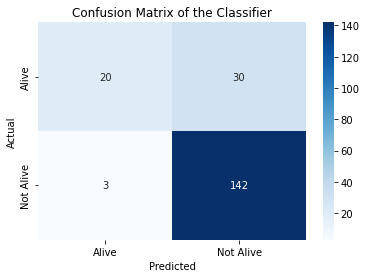

In [549]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred,
          labels = ['Alive', 'Not Alive'])

<h4>Hyperparameter Tuning</h4>

In [550]:
# # declaring a hyperparameter space
# C_range          = np.arange(0.1, 5.0, 0.1)
# warm_start_range = [True, False]
# solver_range     = ['newton-cg', 'sag', 'lbfgs']


# # creating a hyperparameter grid
# param_grid = {'C'          : C_range,
#               'warm_start' : warm_start_range,
#               'solver'     : solver_range}


# # INSTANTIATING the model object without hyperparameters
# tuned_logreg = LogisticRegression(random_state = 219,
#                                   max_iter     = 1000) # increased for convergence


# # GridSearchCV object
# tuned_logreg_cv = RandomizedSearchCV(estimator           = tuned_logreg,   # the model object
#                                      param_distributions = param_grid, # parameters to tune
#                                      cv                  = 3,          # how many folds in cross-validation
#                                      n_iter              = 250,        # number of combinations of hyperparameters to try
#                                      random_state        = 219,        # starting point for random sequence
#                                      scoring = make_scorer(roc_auc_score,
#                                                            needs_threshold = False)) # scoring criteria (AUC)


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_logreg_cv.fit(got_data, got_target)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_logreg_cv.best_params_)
# print("Tuned CV AUC      :", tuned_logreg_cv.best_score_.round(4))

In [551]:
# # checking the best estimator for the model
# tuned_logreg_cv.best_estimator_

Implement the parameters

In [552]:
# INSTANTIATING a logistic regression model
tuned_logreg = LogisticRegression(solver       = 'newton-cg',
                                  C            = 3.9000000000000004,
                                  warm_start   = True,
                                  max_iter     = 1000,
                                  random_state = 219)


# FITTING the training data
tuned_logreg_fit = tuned_logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
tuned_logreg_pred = tuned_logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', tuned_logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tuned_logreg_fit.score(x_test, y_test).round(4))

# SCORING with AUC
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tuned_logreg_pred).round(4))

# saving scoring data for future use
tuned_logreg_train_score = tuned_logreg_fit.score(x_train, y_train).round(4) # accuracy
tuned_logreg_test_score  = tuned_logreg_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score
tuned_logreg_auc_score = roc_auc_score(y_true  = y_test,
                                       y_score = tuned_logreg_pred).round(4)

Training ACCURACY: 0.7796
Testing  ACCURACY: 0.8308
AUC Score        : 0.6897


Create a confusion matrix

In [553]:
# creating a confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = tuned_logreg_pred)

# unpacking the confusion matrix
tuned_logreg_tn, \
tuned_logreg_fp, \
tuned_logreg_fn, \
tuned_logreg_tp = confusion_matrix(y_true = y_test, y_pred = tuned_logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_logreg_tn}
False Positives: {tuned_logreg_fp}
False Negatives: {tuned_logreg_fn}
True Positives : {tuned_logreg_tp}
""")


True Negatives : 20
False Positives: 30
False Negatives: 3
True Positives : 142



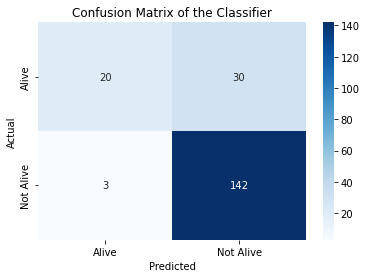

In [554]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = tuned_logreg_pred,
          labels = ['Alive', 'Not Alive'])

<h2>Classification Trees (CART Models)</h4>

<h4>Define a function</h4>

In [555]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

<h4>Develop a classification tree model</h4>

In [556]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.8658
Full Tree Testing ACCURACY : 0.8359
Full Tree AUC Score: 0.7521


Unpack the confustion matrix

In [557]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 29
False Positives: 21
False Negatives: 11
True Positives : 134



Visual the full tree output

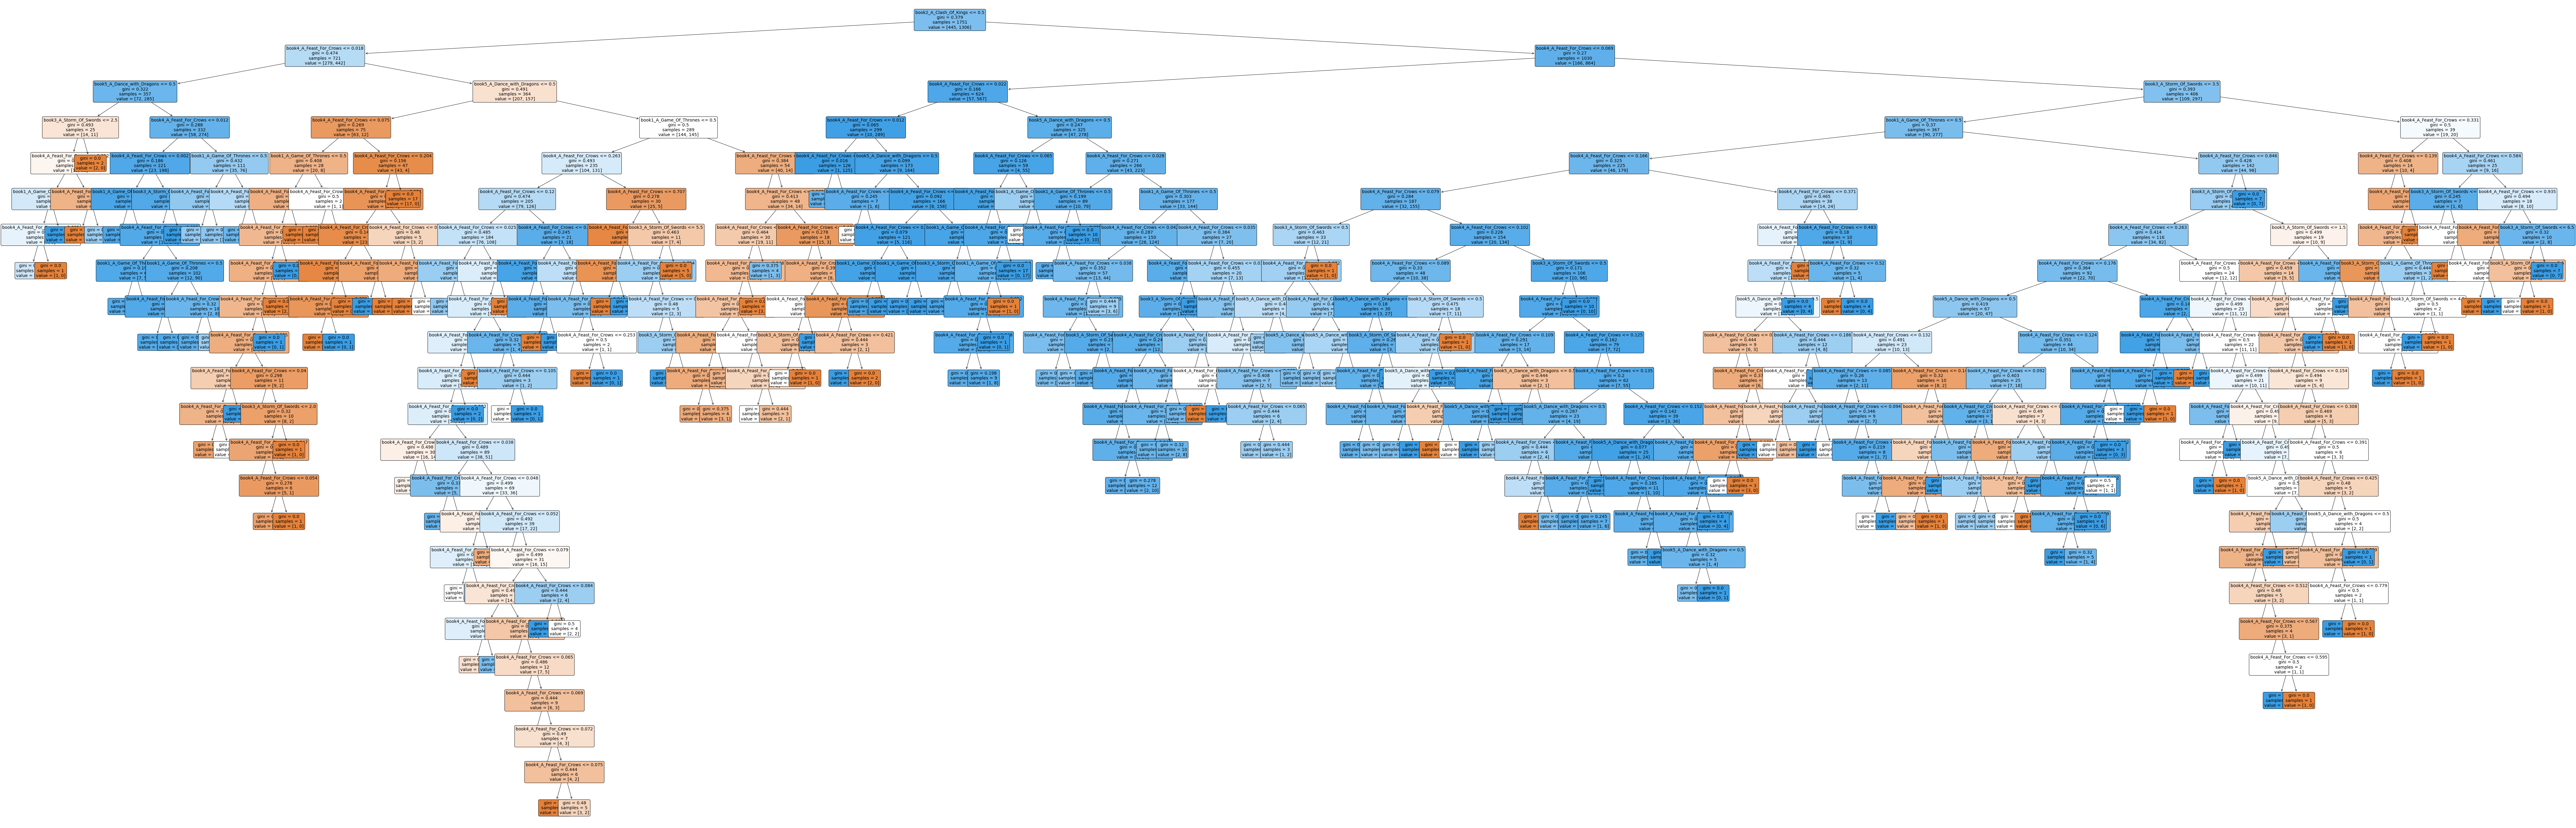

In [558]:
# setting figure size
plt.figure(figsize=(150,50))

# developing a plotted tree
plot_tree(decision_tree = full_tree_fit, 
          feature_names = got.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)

# rendering the plot
plt.show()

<h4>Develop a pruned tree model</h4>

In [559]:
# INSTANTIATING a classification tree object
tree_pruned = DecisionTreeClassifier(max_depth        = 8,
                                     min_samples_leaf = 1,
                                     random_state     = 219)

# FITTING the training data
tree_pruned_fit = tree_pruned.fit(x_train, y_train)


# PREDICTING on new data
tree_pruned_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pruned_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tree_pruned_pred).round(4) # auc

Training ACCURACY: 0.827
Testing  ACCURACY: 0.8564
AUC Score        : 0.7593


Unpack confusion matrix

In [560]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_pruned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 28
False Positives: 22
False Negatives: 6
True Positives : 139



Visual the tree

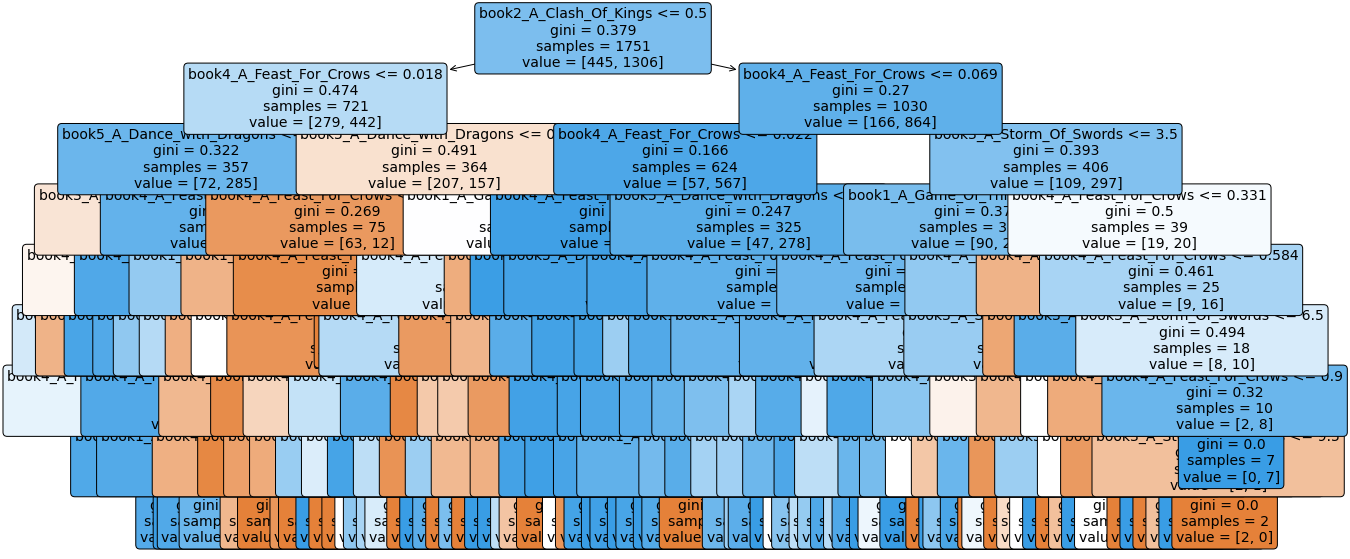

In [561]:
# setting figure size
plt.figure(figsize=(20, 10)) # adjusting to better fit the visual

# developing a plotted tree
plot_tree(decision_tree = tree_pruned_fit, # changing to pruned_tree_fit
          feature_names = got.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)

# rendering the plot
plt.show()

<h4>Hyperparameter Tuning</h4>

In [562]:
# # declaring a hyperparameter space
# criterion_range = ['gini', 'entropy']
# splitter_range  = ['best', 'random']
# depth_range     = np.arange(1, 8, 1)
# leaf_range      = np.arange(1, 100, 1)


# # creating a hyperparameter grid
# param_grid = {'criterion'        : criterion_range,
#               'splitter'         : splitter_range,
#               'max_depth'        : depth_range,
#               'min_samples_leaf' : leaf_range}


# # INSTANTIATING the model object without hyperparameters
# tuned_tree = DecisionTreeClassifier(random_state = 219)


# # RandomizedSearchCV object
# tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 1000,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_tree_cv.fit(got_data, got_target)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_tree_cv.best_params_)
# print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

In [563]:
# # checking the best estimator for the model
# tuned_tree_cv.best_estimator_

Implement the parameters

In [564]:
# INSTANTIATING a classification tree object
tuned_tree_pruned = DecisionTreeClassifier(max_depth       = 5,
                                          min_samples_leaf = 2,
                                          random_state     = 219,
                                          criterion        = 'gini',
                                          splitter         = 'best')

# FITTING the training data
tuned_tree_pruned_fit = tree_pruned.fit(x_train, y_train)


# PREDICTING on new data
tuned_tree_pruned_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tuned_tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tuned_tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tuned_tree_pruned_pred).round(4))


# saving scoring data for future use
tuned_pruned_tree_train_score = tuned_tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
tuned_pruned_tree_test_score  = tuned_tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


# saving auc score
tuned_pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                              y_score = tuned_tree_pruned_pred).round(4) # auc

Training ACCURACY: 0.827
Testing  ACCURACY: 0.8564
AUC Score        : 0.7593


<h4>Unpack the confustion matrix</h4>

In [565]:
# unpacking the confusion matrix
tuned_pruned_tree_tn, \
tuned_pruned_tree_fp, \
tuned_pruned_tree_fn, \
tuned_pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tuned_tree_pruned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_pruned_tree_tn}
False Positives: {tuned_pruned_tree_fp}
False Negatives: {tuned_pruned_tree_fn}
True Positives : {tuned_pruned_tree_tp}
""")


True Negatives : 28
False Positives: 22
False Negatives: 6
True Positives : 139



Visual the tree output

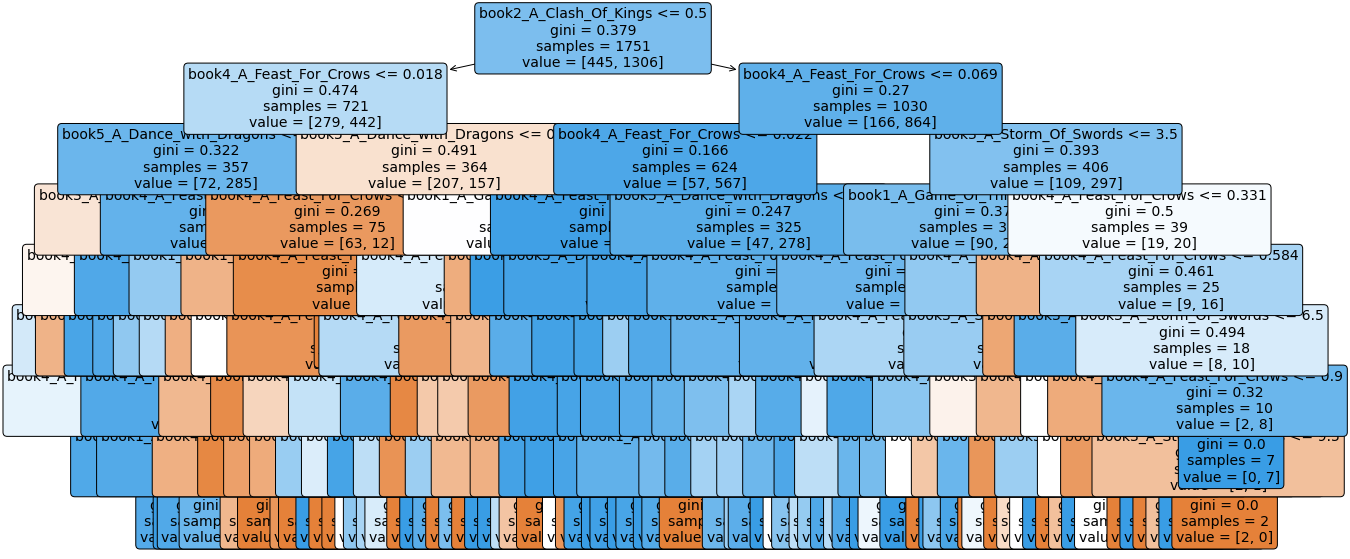

In [566]:
# setting figure size
plt.figure(figsize=(20, 10)) # adjusting to better fit the visual

# developing a plotted tree
plot_tree(decision_tree = tuned_tree_pruned_fit, # changing to pruned_tree_fit
          feature_names = got.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)

# rendering the plot
plt.show()

Plot to see feature importance

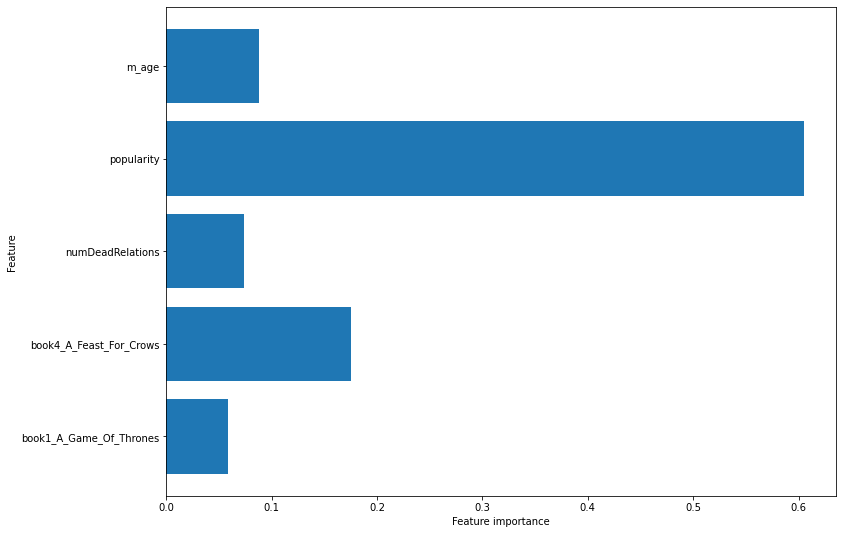

In [567]:
# plotting feature importance
plot_feature_importances(tuned_tree_pruned_fit,
                         train = x_train,
                         export = False)

<h2>Classification Modeling with KNN</h2>

<h4>Find the optimal neighbors</h4>

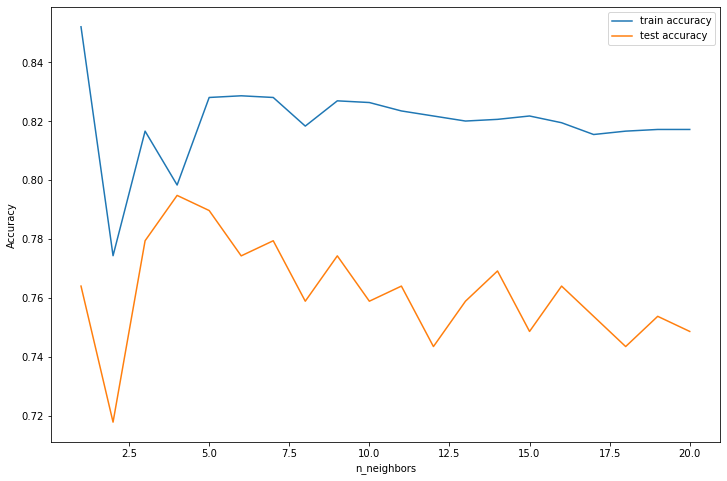

The optimal number of neighbors is: 4


In [568]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = got_data,
                                  y_data        = got_target,
                                  response_type = 'class')

<h4>Build KNN model</h4>

In [569]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(got_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(got_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            got_target,
            random_state = 219,
            test_size    = 0.1,
            stratify     = got_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.795
Testing  ACCURACY: 0.7897
AUC Score        : 0.7472


Unpack the confusion matrix

In [570]:
# unpacking the confusion matrix
knn_tn, \
knn_fp, \
knn_fn, \
knn_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_tn}
False Positives: {knn_fp}
False Negatives: {knn_fn}
True Positives : {knn_tp}
""")


True Negatives : 33
False Positives: 17
False Negatives: 24
True Positives : 121



Visual the comfusion matrix

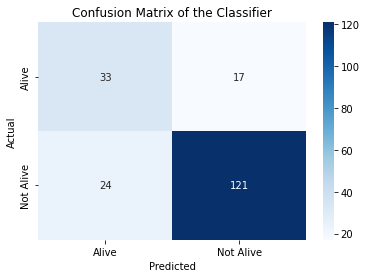

In [571]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = knn_pred,
          labels = ['Alive', 'Not Alive'])

<h2>Random Forest</h2>

In [572]:
# importing new packages
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

In [573]:
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results and AUC score
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

# saving the results
rf_train_score = rf_default_fit.score(x_train, y_train).round(4)
rf_test_score  = rf_default_fit.score(x_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)

Training ACCURACY: 0.8658
Testing  ACCURACY: 0.841
AUC Score        : 0.7424


Unpack confusion matrix

In [574]:
# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 27
False Positives: 23
False Negatives: 8
True Positives : 137



<h4>Hyperparameter Tuning</h4>

In [575]:
# # declaring a hyperparameter space
# estimator_range  = np.arange(100, 1100, 250)
# leaf_range       = np.arange(1, 31, 10)
# criterion_range  = ['gini', 'entropy']
# bootstrap_range  = [True, False]
# warm_start_range = [True, False]


# # creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_range,
#               'min_samples_leaf' : leaf_range,
#               'criterion'        : criterion_range,
#               'bootstrap'        : bootstrap_range,
#               'warm_start'       : warm_start_range}


# # INSTANTIATING the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 219)


# # GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 1000,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# forest_cv.fit(got_data, got_target)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(4))

In [576]:
# # best estimators based on RandomizedSearchCV
# forest_cv.best_estimator_

Inplement the parameters

In [577]:
# building a model based on hyperparameter tuning results

# INSTANTIATING with best_estimator
tuned_rf = RandomForestClassifier(criterion        = 'entropy',
                                  min_samples_leaf = 1,
                                  n_estimators     = 100,
                                  warm_start       = True,
                                  bootstrap        = True,
                                  random_state     = 219)


# FITTING to the FULL DATASET (due to cross-validation)
tuned_rf_fit = tuned_rf.fit(got_data, got_target)


# PREDICTING based on the testing set
tuned_rf_pred = tuned_rf_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', tuned_rf.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', tuned_rf.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = tuned_rf_pred).round(4))


# saving scoring data for future use
tuned_rf_train_score = tuned_rf.score(x_train, y_train).round(4) # accuracy
tuned_rf_test_score  = tuned_rf.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tuned_rf_auc = roc_auc_score(y_true  = y_test,
                             y_score = tuned_rf_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.8641
Forest Tuned Testing  ACCURACY: 0.9179
Forest Tuned AUC Score        : 0.8466


Unpack confusion matrix

In [578]:
# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = tuned_rf_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")


True Negatives : 35
False Positives: 15
False Negatives: 1
True Positives : 144



Visual feature importance plot

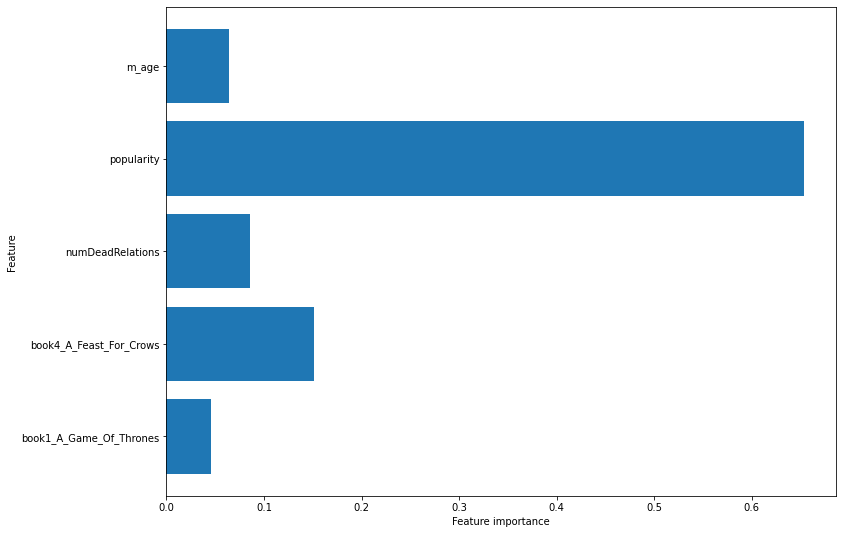

In [579]:
# plotting feature importances
plot_feature_importances(tuned_rf_fit,
                         train = x_train,
                         export = False)

<h2>Compare results</h2>

In [580]:
# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Tuned Logistic', 'Full Tree', 'Pruned Tree', 
                       'Tuned Pruned Tree', 'KNN', 'Random Forest', 'Tuned Random Forest'],
                           
    'Training Accuracy'  : [logreg_train_score, tuned_logreg_train_score, 
                            full_tree_train_score, pruned_tree_train_score, 
                            tuned_pruned_tree_train_score, knn_train_score, 
                            rf_train_score, tuned_rf_train_score],
                           
    'Testing Accuracy'   : [logreg_test_score, tuned_logreg_test_score, 
                            full_tree_test_score, pruned_tree_test_score, 
                            tuned_pruned_tree_test_score, knn_test_score, 
                            rf_test_score, tuned_rf_test_score],
                           
    'AUC Score'          : [logreg_auc_score, tuned_logreg_auc_score, 
                            full_tree_auc_score, pruned_tree_auc_score, 
                            tuned_pruned_tree_auc_score, knn_auc_score,
                            rf_auc, tuned_rf_auc],
                           
    'Confusion Matrix'   : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp), 
                            (tuned_logreg_tn, tuned_logreg_fp, tuned_logreg_fn, tuned_logreg_tp), 
                            (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp), 
                            (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp), 
                            (tuned_pruned_tree_tn, tuned_pruned_tree_fp, tuned_pruned_tree_fn, tuned_pruned_tree_tp), 
                            (knn_tn, knn_fp, knn_fn, knn_tp), 
                            (rf_tn, rf_fp, rf_fn, rf_tp), 
                            (tuned_rf_tn, tuned_rf_fp, tuned_rf_fn, tuned_rf_tp)]}

# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)

# checking the results
model_performance

Model Name  Training Accuracy  Testing Accuracy  AUC Score   Confusion Matrix
0             Logistic             0.7790            0.8308     0.6897   (20, 30, 3, 142)
1       Tuned Logistic             0.7796            0.8308     0.6897   (20, 30, 3, 142)
2            Full Tree             0.8658            0.8359     0.7521  (29, 21, 11, 134)
3          Pruned Tree             0.8270            0.8564     0.7593   (28, 22, 6, 139)
4    Tuned Pruned Tree             0.8270            0.8564     0.7593   (28, 22, 6, 139)
5                  KNN             0.7950            0.7897     0.7472  (33, 17, 24, 121)
6        Random Forest             0.8658            0.8410     0.7424   (27, 23, 8, 137)
7  Tuned Random Forest             0.8641            0.9179     0.8466   (35, 15, 1, 144)

In [581]:
#looping for final output
for index, val in model_performance.iterrows():
    
    # finding the highest auc score
    if model_performance.loc[index, 'AUC Score'] == model_performance['AUC Score'].max():
        
        # printing the final model
        print(model_performance.loc[index, 'Model Name']+' is the final model.')

Tuned Random Forest is the final model.
